# Zadaca 1: optimizacija implementacije KNN algoritma upotrebom numpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from typing import Any

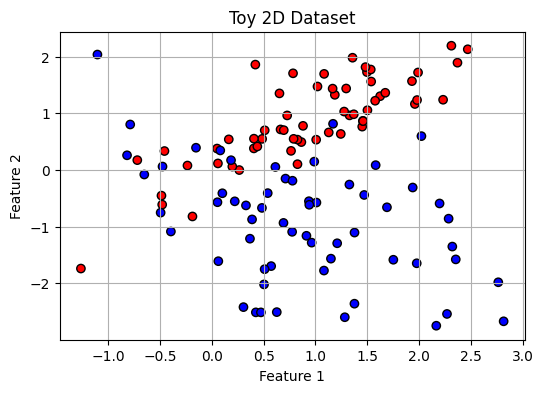

In [2]:
X, y = make_classification(n_samples=120, n_features=2, n_redundant=0, 
                           n_clusters_per_class=1, n_classes=2, random_state=42)

plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')
plt.title("Toy 2D Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

In [3]:
class KNNManual:
    def __init__(self, k: int = 3, weighted: bool = False) -> None:
        self.k: int = k
        self.weighted: bool = weighted

    def fit(self, X: list[list[float]] | np.ndarray, y: list[Any] | np.ndarray) -> None:
        X_arr = np.asarray(X, dtype=float)
        self.X_train: list[list[float]] = X_arr.tolist()
        self.y_train: list[Any] = list(y)

    def _euclidean_distance(self, x1: list[float], x2: list[float]) -> float:
        return sum((a - b) ** 2 for a, b in zip(x1, x2)) ** 0.5

    def _get_k_neighbors(self, x_test: list[float]) -> tuple[list[int], list[float]]:
        distances = [self._euclidean_distance(x_test, x_train) for x_train in self.X_train]
        sorted_idx = sorted(range(len(distances)), key=lambda i: distances[i])
        k_idx = sorted_idx[:self.k]
        return k_idx, [distances[i] for i in k_idx]

    def _majority_vote(self, labels: list[Any]) -> Any:
        votes: dict[Any, int] = {}
        for label in labels:
            votes[label] = votes.get(label, 0) + 1
        return max(votes, key=votes.get)

    def _weighted_vote(self, labels: list[Any], distances: list[float]) -> Any:
        weights: dict[Any, float] = {}
        for label, dist in zip(labels, distances):
            w = 1 / (dist + 1e-5)
            weights[label] = weights.get(label, 0) + w
        return max(weights, key=weights.get)

    def predict(self, X: list[list[float]] | list[float] | np.ndarray) -> list[Any]:
        X_arr = np.asarray(X, dtype=float)
        if X_arr.ndim == 1:
            X_list = [X_arr.tolist()]
        else:
            X_list = X_arr.tolist()

        preds: list[Any] = []
        for x_test in X_list:
            k_idx, k_dist = self._get_k_neighbors(x_test)
            k_labels = [self.y_train[i] for i in k_idx]
            pred = self._weighted_vote(k_labels, k_dist) if self.weighted else self._majority_vote(k_labels)
            preds.append(pred)
        return preds

## Zadatak 1

Oslanjajući se na prethodno definisanu KNN implementaciju refaktorisati sve funkcije tako da umjesto upotrebe for petlji i Python listi što više koriste numpy funkcije za rad sa numpy nizovima. Koristiti funkciju euclidean_distance za primjer.

In [4]:
class KNN:
    def __init__(self, k: int = 3, weighted: bool = False) -> None:
        self.k: int = k
        self.weighted: bool = weighted

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self.X_train = X.astype(float)
        self.y_train = y

    def _compute_distances(self, X: np.ndarray) -> np.ndarray:
        X = X.astype(float)
        return np.sqrt(((X[:, None, :] - self.X_train[None, :, :]) ** 2).sum(axis=2))

    def _uniform_vote(self, labels: np.ndarray) -> np.ndarray:
        def mode(row: np.ndarray) -> Any:
            unique, counts = np.unique(row, return_counts=True)
            return unique[np.argmax(counts)]
        return np.apply_along_axis(mode, 1, labels)

    def _weighted_vote(self, labels: np.ndarray, distances: np.ndarray) -> np.ndarray:
        weights = 1.0 / (distances + 1e-5)
        preds = []
        for lab_row, wt_row in zip(labels, weights):
            unique = np.unique(lab_row)
            total = np.array([wt_row[lab_row == u].sum() for u in unique])
            preds.append(unique[np.argmax(total)])
        return np.array(preds)

    def predict(self, X: np.ndarray | list[list[float]] | list[float]) -> np.ndarray:
        X_arr = np.asarray(X, dtype=float)
        if X_arr.ndim == 1:
            X_arr = X_arr.reshape(1, -1)
        dists = self._compute_distances(X_arr)
        idx = np.argpartition(dists, self.k, axis=1)[:, :self.k]
        lab_k = self.y_train[idx]
        dist_k = np.take_along_axis(dists, idx, axis=1)
        return self._uniform_vote(lab_k) if not self.weighted else self._weighted_vote(lab_k, dist_k)


## Zadatak 2

Testirati i prokomentarisati brzinu rada optimizovane i neoptimizovane verzije na različitim veličinama ulaznih skupova podataka.

In [5]:
X_s, y_s = make_classification(n_samples=10, n_features=2, n_redundant=0, 
                           n_clusters_per_class=1, n_classes=2, random_state=42)

In [6]:
X_m, y_m = make_classification(n_samples=500, n_features=2, n_redundant=0, 
                           n_clusters_per_class=1, n_classes=2, random_state=42)

In [7]:
X_l, y_l = make_classification(n_samples=10000, n_features=2, n_redundant=0, 
                           n_clusters_per_class=1, n_classes=2, random_state=42)

In [8]:
X_xl, y_xl = make_classification(n_samples=200000, n_features=2, n_redundant=0, 
                           n_clusters_per_class=1, n_classes=2, random_state=42)

In [9]:
new_point = np.array([1.0, 2.0])

In [10]:
knn_np = KNN(k=3, weighted=True)
knn_man = KNNManual(k=3, weighted=True)

knn_np.fit(X_s, y_s)
knn_man.fit(X_s, y_s)

In [11]:
%%timeit
knn_man.predict(new_point)

6.39 μs ± 43.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [12]:
%%timeit
knn_np.predict(new_point)

15.9 μs ± 161 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [13]:
knn_np = KNN(k=3, weighted=True)
knn_man = KNNManual(k=3, weighted=True)

knn_np.fit(X_xl, y_xl)
knn_man.fit(X_xl, y_xl)

In [14]:
%%timeit
knn_man.predict(new_point)

150 ms ± 7.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
%%timeit
knn_np.predict(new_point)

5.09 ms ± 139 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
